# Determining $\Sigma_{10}$ & $R_{10}$ of DESIJ1501+5208

Author(s): Md Mamun Hossain Nahid, S M Rafee Adnan, Sulyman Hossain, Anowar Shajib  <br>
Acknowledgement(s): Rajit, Ahmad Al - Imtiaz, Mamunur Rashid


## Load data

In [1]:
!pip install photutils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 738.7/738.7 kB 30.9 MB/s eta 0:00:00


In [2]:
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy.stats import SigmaClip
from astropy.visualization import simple_norm
from astropy.wcs import WCS
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import (
    SourceCatalog,
    SourceFinder,
    deblend_sources,
    detect_sources,
)

In [3]:
data, header = fits.getdata(
    "/kaggle/input/fits-file/DESIJ15015208_F140W_drz_sci.fits", header=True
)

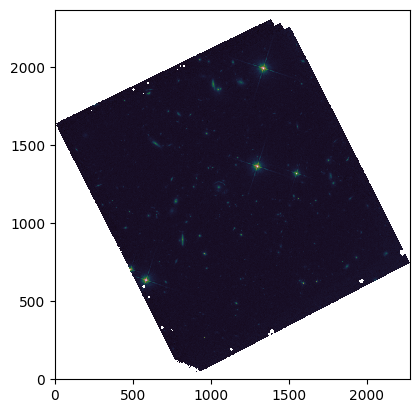

In [4]:
plt.imshow(np.log10(data), origin="lower", cmap="cubehelix", interpolation="nearest")

## Background estimation

In [5]:
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()
bkg = Background2D(
    data,
    (50, 50),
    filter_size=(3, 3),
    sigma_clip=sigma_clip,
    bkg_estimator=bkg_estimator,
)

/tmp/ipykernel_17/1236197877.py:2: RuntimeWarning: divide by zero encountered in log10
  np.log10(data - bkg.background),
/tmp/ipykernel_17/1236197877.py:2: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


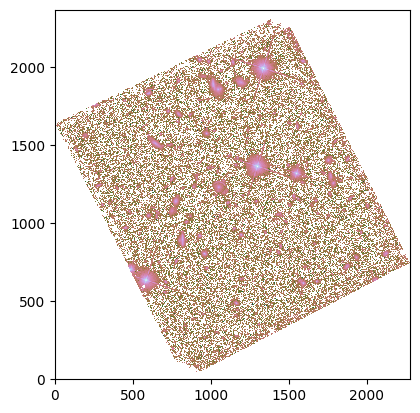

In [6]:
plt.imshow(
    np.log10(data - bkg.background),
    origin="lower",
    cmap="cubehelix",
    interpolation="nearest",
)

## Aperture photometry

In [7]:
np.median(bkg.background), np.median(bkg.background_rms)

(0.24040557, 0.014961391)

In [8]:
bkg_subtracted_data = data - bkg.background

In [9]:
threshold = 4 * bkg.background_rms

In [10]:
segment_map = detect_sources(bkg_subtracted_data, threshold, npixels=10)

In [11]:
segm_deblend = deblend_sources(
    bkg_subtracted_data,
    segment_map,
    npixels=8,
    nlevels=32,
    contrast=0.001,
    progress_bar=False,
)

In [12]:
finder = SourceFinder(npixels=10, progress_bar=False)
segment_map = finder(bkg_subtracted_data, threshold)

print(segment_map)

<photutils.segmentation.core.SegmentationImage>
shape: (2371, 2279)
nlabels: 645
labels: [  1   2   3   4   5 ... 641 642 643 644 645]


In [13]:
cat = SourceCatalog(bkg_subtracted_data, segm_deblend)
print(cat)
print(type(cat))

<photutils.segmentation.catalog.SourceCatalog>
Length: 658
labels: [  1   2   3   4   5 ... 654 655 656 657 658]
<class 'photutils.segmentation.catalog.SourceCatalog'>


## Adjust the region near your lensing system

In [14]:
set_x_lim1, set_x_lim2 = 800, 1100 + 130
set_y_lim1, set_y_lim2 = 1000, 1300 + 120

/tmp/ipykernel_17/872409002.py:5: RuntimeWarning: divide by zero encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/tmp/ipykernel_17/872409002.py:5: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


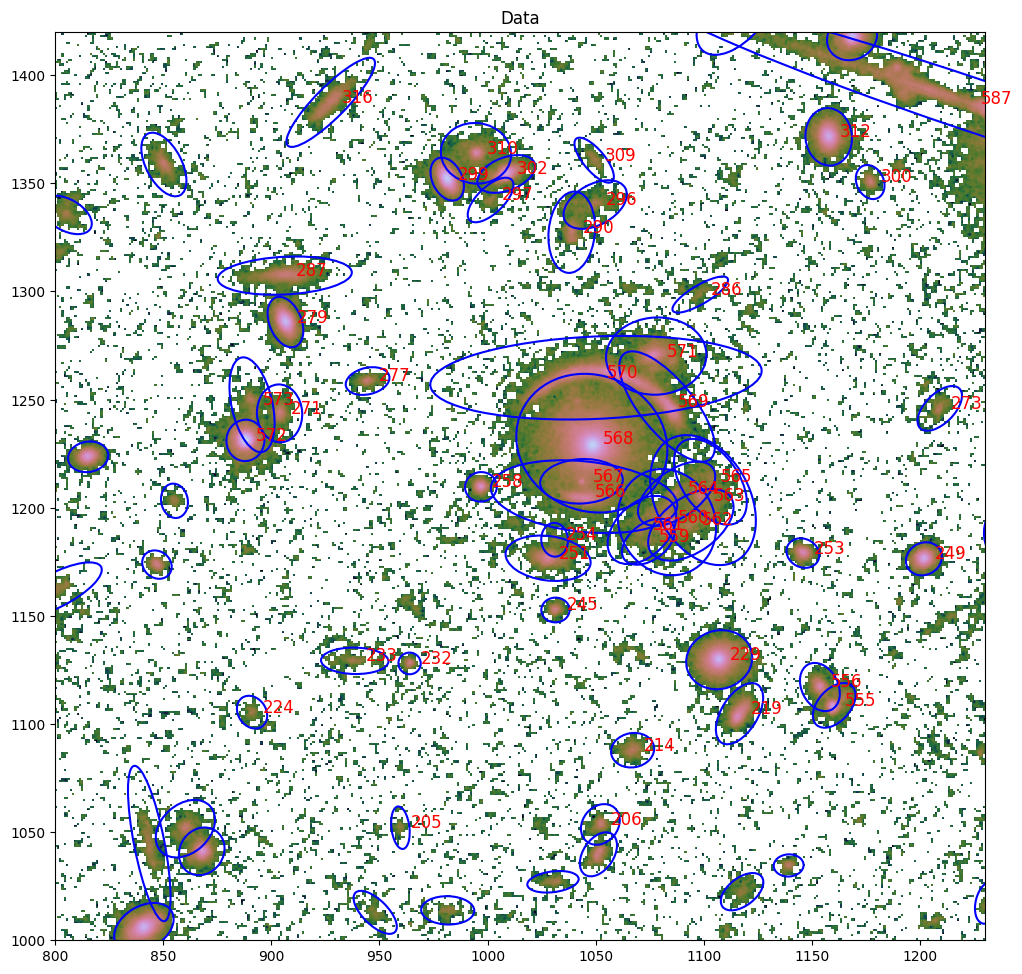

In [15]:
norm = simple_norm(data, "sqrt")

fig, ax1 = plt.subplots(1, 1, figsize=(12, 12))
ax1.imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
ax1.set_title("Data")

cat.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)

"""
#Before determining the central ID

for i in range(len(cat)):
    ax1.text(
         cat.xcentroid[i] + 5,
         cat.ycentroid[i],
         f"{i}",
         c="r",
         fontsize=12
    )
"""
# After determining the central ID
id_central = 568
for i in range(len(cat)):
    if (
        np.abs(cat.xcentroid[i] - cat.xcentroid[id_central]) < 180
        and np.abs(cat.ycentroid[i] - cat.ycentroid[id_central]) < 180
    ):
        ax1.text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

ax1.set_xlim(set_x_lim1, set_x_lim2)
ax1.set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)

## Determine the central deflector's ID

/tmp/ipykernel_17/1281281835.py:8: RuntimeWarning: divide by zero encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/tmp/ipykernel_17/1281281835.py:8: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


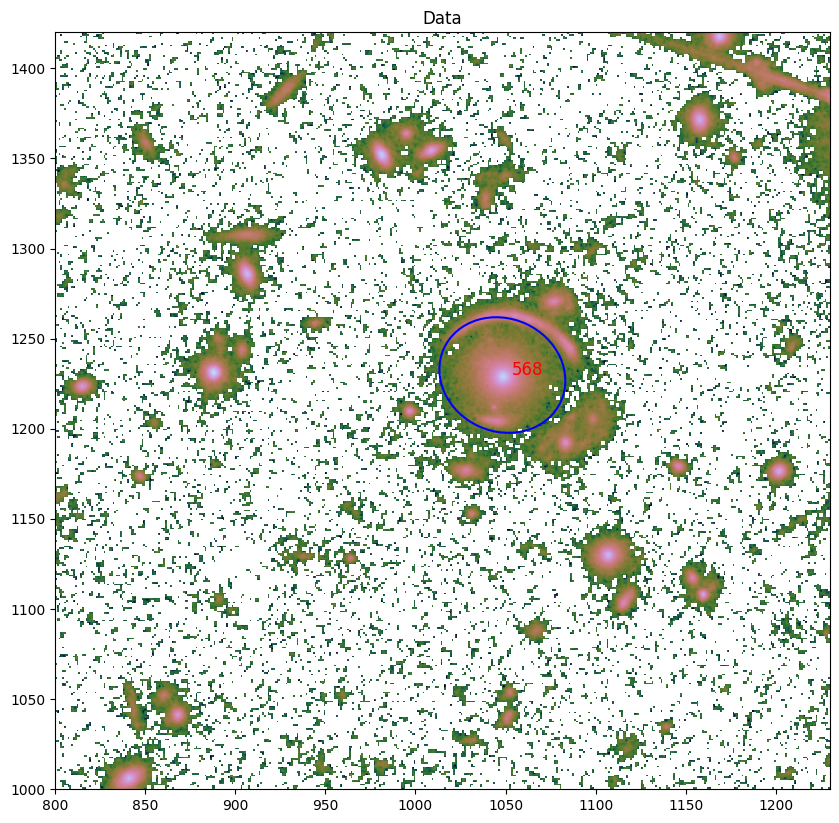

In [16]:
# object id of your central deflector/lens
id_central = 568

norm = simple_norm(data, "sqrt")

fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
ax1.imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
ax1.set_title("Data")

labels_1 = [id_central + 1]
cat_subset_1 = cat.get_labels(labels_1)

cat_subset_1.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)

ax1.text(
    cat.xcentroid[id_central] + 5,
    cat.ycentroid[id_central],
    f"{id_central}",
    c="r",
    fontsize=12
    # transform=ax1.transAxes
)

ax1.set_xlim(set_x_lim1, set_x_lim2)
ax1.set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)

In [17]:
tbl = cat.to_table()
tbl["xcentroid"].info.format = ".2f"  # optional format
tbl["ycentroid"].info.format = ".2f"
tbl["kron_flux"].info.format = ".2f"

## Creating List of neighbouring Galaxies

In [18]:
# All close galaxies

x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_all = []
dist_galaxies_all = []
flux_galaxies_all = []
axis_ratios_all = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 20 / 0.08:
        close_galaxies_all.append(i)
        flux_galaxies_all.append(f)
        dist_galaxies_all.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_all.append(np.sqrt(1 - tbl[i]["eccentricity"].value ** 2))

print(
    "Number of All Close galaxies within 20 arcseconds radius:", len(close_galaxies_all)
)

Number of All Close galaxies within 20 arcseconds radius: 65


In [19]:
# close galaxies excluding sources lower than 1% of the central deflector

x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_1 = []
dist_galaxies_1 = []
flux_galaxies_1 = []
axis_ratios_1 = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if (np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 20 / 0.08) & (f > f0 * 0.01):
        close_galaxies_1.append(i)
        flux_galaxies_1.append(f)
        dist_galaxies_1.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_1.append(np.sqrt(1 - tbl[i]["eccentricity"].value ** 2))
print(
    "Number of Close galaxies (excluding the dim sources) within 20 arcseconds radius:",
    len(close_galaxies_1),
)

Number of Close galaxies (excluding the dim sources) within 20 arcseconds radius: 51


In [20]:
def distance_parsec(pixel_distance, z):
    """Convert distance from unit of pixels into parsec unit.

    :param pixel_distance: distance in unit of pixels

    :param z: photometric redshift

    :return: distance in parsec unit

    """

    wcs = WCS(header)

    # Get the pixel scale in degrees per pixel
    pix_scale_deg = abs(wcs.wcs.cd[0, 0])

    # Convert the pixel scale from degrees to radians
    pix_scale_radian = pix_scale_deg * np.pi / 180

    # Angles in radians
    angles_radian = pixel_distance * pix_scale_radian

    # Define cosmological parameters
    H0 = 70  # Hubble constant in km/s/Mpc
    Om0 = 0.3  # Matter density parameter
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)

    # Compute the angular diameter distance
    angular_diameter_distance = cosmo.angular_diameter_distance(z)

    # Calculate the physical distance
    physical_distances_mpc = angular_diameter_distance * angles_radian

    return physical_distances_mpc

In [21]:
remove_list = [
    568,  # This is the central deflector
    566,  # Object is part of the lensed arc
    569,  # Object is part of the lensed arc
    570,  # Object is part of the lensed arc
    559,  # Halo of the objects 560 & 563
    561,  # Halo of the objects 560 & 563
    562,  # Halo of the objects 560 & 563
    564,  # Halo of the objects 560 & 563
    565,  # Halo of the objects 560 & 563
    254,  # Halo of the objects 251
    563,
    560,
    299,
    279,
    271,
    229,
    572,
]

df_all = pd.DataFrame({"Distance(pixels)": dist_galaxies_all})

df_all.set_index(pd.Index(close_galaxies_all), inplace=True)

# Photometric redshift of the deflector galaxy is 0.752
df_all["Distance(megaparsec)"] = distance_parsec(df_all["Distance(pixels)"], 0.752)
df_all["Flux"] = flux_galaxies_all
df_all["Axis Ratio"] = axis_ratios_all

# Sort the DataFrame based on 'Distance'
df_all_sorted = df_all.sort_values(by="Distance(pixels)")

# Exclude unwanted sources
df_all_sys_removed = df_all_sorted.drop(remove_list)

# first 20 galaxies
df_all_20 = df_all_sys_removed.iloc[:20]

print(df_all_20.shape)
print(df_all_20)

(20, 4)
     Distance(pixels)  Distance(megaparsec)       Flux  Axis Ratio
567         18.269057              0.010735  17.133906    0.537012
571         50.076120              0.029426  51.247054    0.768467
258         55.113127              0.032386  14.951930    0.926341
251         56.920544              0.033448  28.261039    0.518586
245         78.948143              0.046392   5.681433    0.876158
286         85.044639              0.049975   2.884005    0.295082
290         97.969927              0.057570  15.282268    0.567030
277        107.592566              0.063224   6.257132    0.594901
253        110.027165              0.064655  14.633284    0.837625
296        110.346906              0.064843  11.288070    0.594476
297        121.791271              0.071568   4.755994    0.452175
302        130.612135              0.076751  49.678922    0.542576
309        130.860370              0.076897   3.950173    0.383504
232        132.183119              0.077674   3.859222

In [22]:
remove_list_1 = [
    568,  # This is the central deflector
    566,  # Object is part of the lensed arc
    569,  # Object is part of the lensed arc
    570,  # Object is part of the lensed arc
    559,  # Halo of the objects 560 & 563
    561,  # Halo of the objects 560 & 563
    562,  # Halo of the objects 560 & 563
    564,  # Halo of the objects 560 & 563
    565,  # Halo of the objects 560 & 563
    563,
    560,
    299,
    279,
    271,
    229,
    572,
]


df_1 = pd.DataFrame({"Distance(pixels)": dist_galaxies_1})

df_1.set_index(pd.Index(close_galaxies_1), inplace=True)

# Photometric redshift of the deflector galaxy is 0.752
df_1["Distance(megaparsec)"] = distance_parsec(df_1["Distance(pixels)"], 0.752)
df_1["Flux"] = flux_galaxies_1
df_1["Axis Ratio"] = axis_ratios_1

# Sort the DataFrame based on 'Distance'
df_1_sorted = df_1.sort_values(by="Distance(pixels)")

# Exclude the lensing system members
df_1_sys_removed = df_1_sorted.drop(remove_list_1)

# first 20 galaxies
df_1_20 = df_1_sys_removed.iloc[:20]

print(df_1_20.shape)
print(df_1_20)

(20, 4)
     Distance(pixels)  Distance(megaparsec)       Flux  Axis Ratio
567         18.269057              0.010735  17.133906    0.537012
571         50.076120              0.029426  51.247054    0.768467
258         55.113127              0.032386  14.951930    0.926341
251         56.920544              0.033448  28.261039    0.518586
245         78.948143              0.046392   5.681433    0.876158
290         97.969927              0.057570  15.282268    0.567030
277        107.592566              0.063224   6.257132    0.594901
253        110.027165              0.064655  14.633284    0.837625
296        110.346906              0.064843  11.288070    0.594476
302        130.612135              0.076751  49.678922    0.542576
219        142.489102              0.083730  28.951538    0.529552
214        143.196951              0.084146   7.876575    0.789711
310        144.349215              0.084823  26.342834    0.858535
233        148.803379              0.087441   5.414222

## Determining $\Sigma_{10}$, $\Sigma_{10\ flux\ selected}$, $\Sigma_{20}$, $\Sigma_{20\ flux\ selected}$

In [23]:
zoom = 100
set_x_lim1, set_x_lim2 = 870 - zoom, 1180 + zoom
set_y_lim1, set_y_lim2 = 1070 - zoom, 1390 + zoom

/tmp/ipykernel_17/1669533052.py:17: RuntimeWarning: divide by zero encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/tmp/ipykernel_17/1669533052.py:17: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/tmp/ipykernel_17/1669533052.py:20: RuntimeWarning: divide by zero encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/tmp/ipykernel_17/1669533052.py:20: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/tmp/ipykernel_17/1669533052.py:23: RuntimeWarning: divide by zero encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/tmp/ipykernel_17/1669533052.py:23: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower",

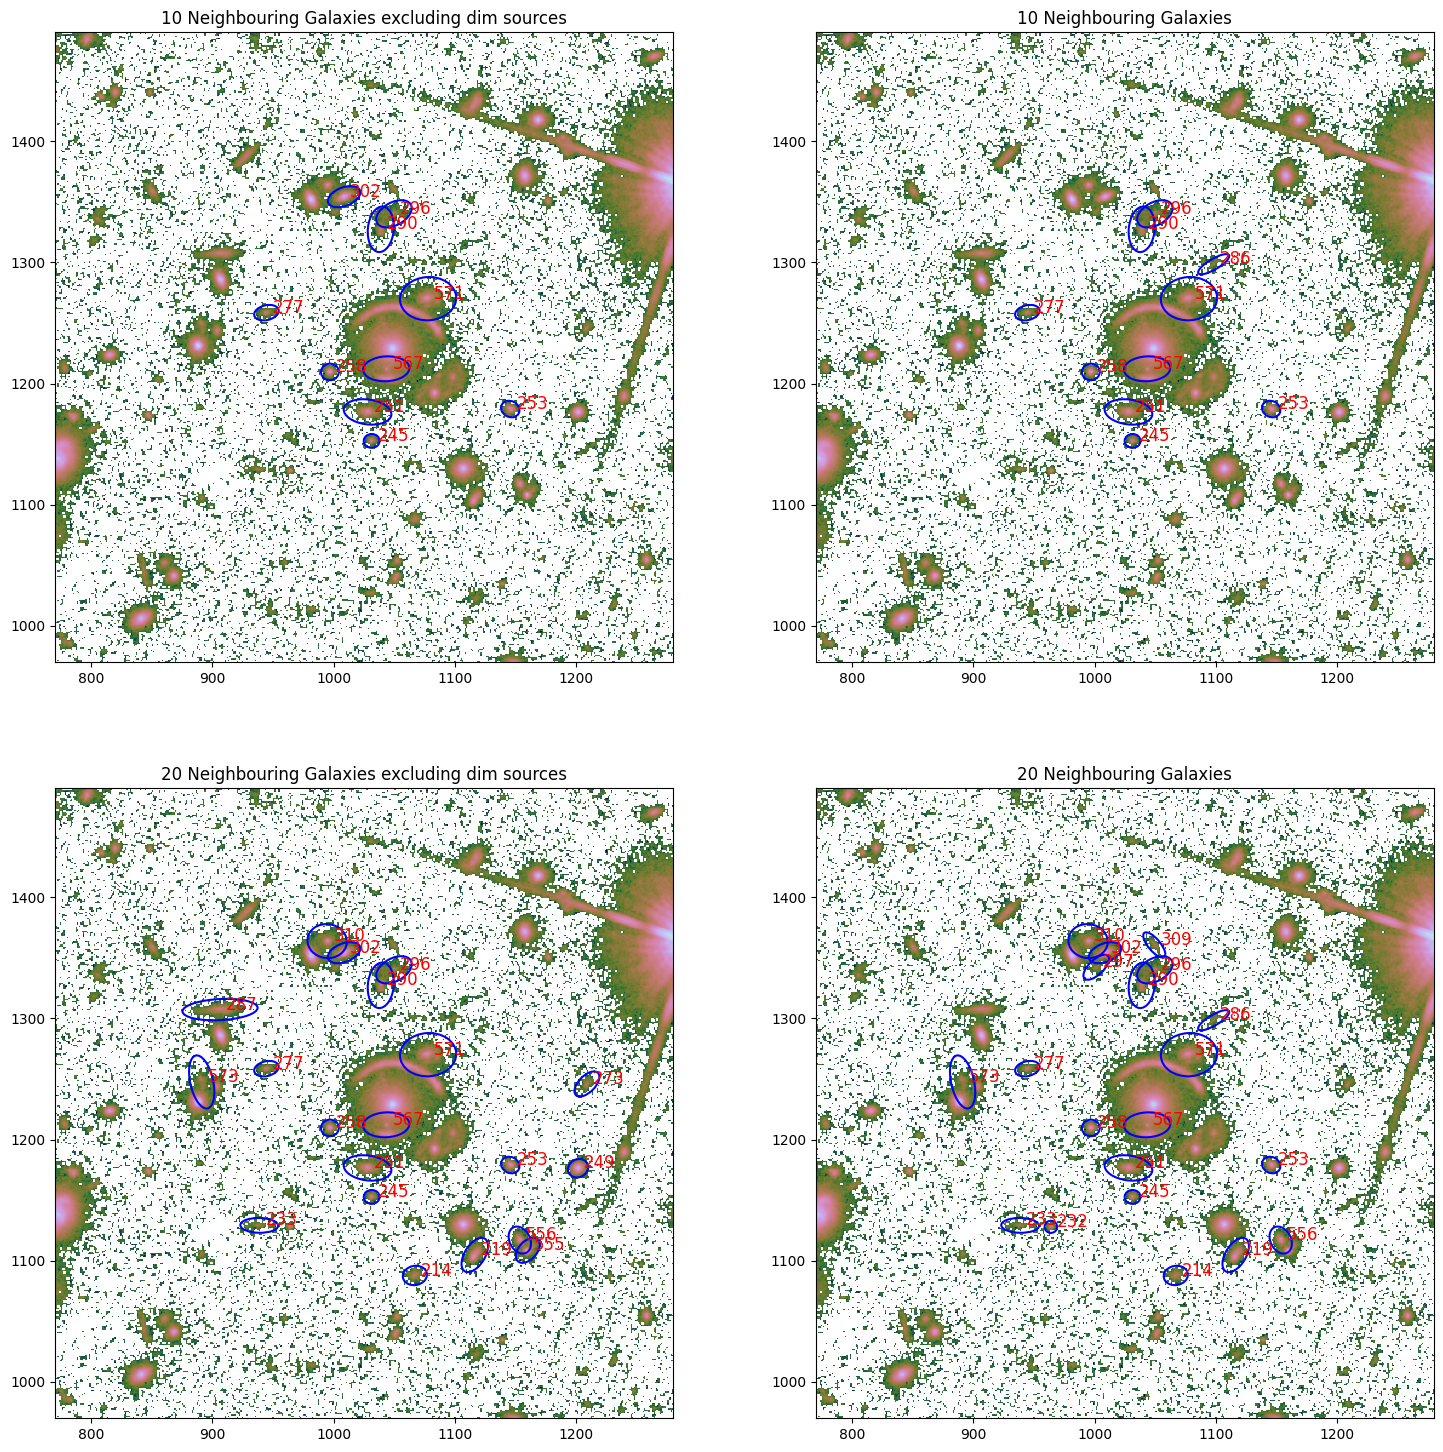

In [24]:
close_ids_all = list(df_all_20.index.values)
close_ids_all_10 = close_ids_all[:10]

updated_close_ids_all = [s + 1 for s in close_ids_all]
updated_close_ids_all_10 = updated_close_ids_all[:10]

close_ids_1 = list(df_1_20.index.values)
close_ids_1_10 = close_ids_1[:10]

updated_close_ids_1 = [s + 1 for s in close_ids_1]
updated_close_ids_1_10 = updated_close_ids_1[:10]

norm = simple_norm(data, "sqrt")
fig, axs = plt.subplots(2, 2, figsize=(18, 18))  # , figsize=(10, 12.5)

axs[0, 0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[0, 1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1, 0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1, 1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)

cat_subset_1_10 = cat.get_labels(updated_close_ids_1_10)
cat_subset_1_10.plot_kron_apertures(ax=axs[0, 0], color="blue", lw=1.5)

cat_subset_all_10 = cat.get_labels(updated_close_ids_all_10)
cat_subset_all_10.plot_kron_apertures(ax=axs[0, 1], color="blue", lw=1.5)

cat_subset_all = cat.get_labels(updated_close_ids_1)
cat_subset_all.plot_kron_apertures(ax=axs[1, 0], color="blue", lw=1.5)

cat_subset_1 = cat.get_labels(updated_close_ids_all)
cat_subset_1.plot_kron_apertures(ax=axs[1, 1], color="blue", lw=1.5)

axs[0, 0].set_title("10 Neighbouring Galaxies excluding dim sources")
axs[0, 1].set_title("10 Neighbouring Galaxies")
axs[1, 0].set_title("20 Neighbouring Galaxies excluding dim sources")
axs[1, 1].set_title("20 Neighbouring Galaxies")

for i in close_ids_1_10:
    axs[0, 0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all_10:
    axs[0, 1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_1:
    axs[1, 0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all:
    axs[1, 1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

axs[0, 0].set_xlim(set_x_lim1, set_x_lim2)
axs[0, 0].set_ylim(set_y_lim1, set_y_lim2)

axs[0, 1].set_xlim(set_x_lim1, set_x_lim2)
axs[0, 1].set_ylim(set_y_lim1, set_y_lim2)

axs[1, 0].set_xlim(set_x_lim1, set_x_lim2)
axs[1, 0].set_ylim(set_y_lim1, set_y_lim2)

axs[1, 1].set_xlim(set_x_lim1, set_x_lim2)
axs[1, 1].set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
axs[0, 0].set_clip_on(True)
axs[0, 0].set_clip_box(axs[0, 0].bbox)

axs[0, 1].set_clip_on(True)
axs[0, 1].set_clip_box(axs[0, 0].bbox)

axs[1, 0].set_clip_on(True)
axs[1, 0].set_clip_box(axs[0, 0].bbox)

axs[1, 1].set_clip_on(True)
axs[1, 1].set_clip_box(axs[0, 0].bbox)

## Calculating $\Sigma_{10}$, $\Sigma_{10,\text{flux selected}}$ , $\Sigma_{20}$, $\Sigma_{20,\text{flux selected}}$ and the corresponding radii

## Loading Global Mean

In [25]:
# Read flux data from each YAML file and append to corresponding lists
input_path = "/kaggle/input/global-means-updated/DESIJ15015208_means.yml"

try:
    with open(input_path, "r") as f:
        data_mean = yaml.safe_load(f)
except (AttributeError, yaml.YAMLError) as e:
    print(f"Failed to load the file: {e}")

global_mean_flux_10 = data_mean.get("Global_mean_flux_10")
global_mean_flux_20 = data_mean.get("Global_mean_flux_20")
global_mean_flux_selected_10 = data_mean.get("Global_mean_flux_selected_10")
global_mean_flux_selected_20 = data_mean.get("Global_mean_flux_selected_20")
global_mean_flux_dis_10 = data_mean.get("Global_mean_flux_dis_10")
global_mean_flux_dis_20 = data_mean.get("Global_mean_flux_dis_20")
global_mean_flux_dis_selected_10 = data_mean.get("Global_mean_flux_dis_selected_10")
global_mean_flux_dis_selected_20 = data_mean.get("Global_mean_flux_dis_selected_20")

## Generating a distribution of the Physical distance using Monte Carlo random sampling to calculate uncertainty in sigma densities

In [26]:
z = 0.752  # redshift
z_uncertainty = 0.073  # redshift's uncertainty

# Define a function to estimate uncertainty in the Physical distance using
# Monte Carlo random sampling


def calculate_physical_distance_distribution(
    pixel_distance, z, z_uncertainty, num_samples=10000
):
    # Generate random samples of redshift using normal distribution
    z_samples = np.random.normal(z, z_uncertainty, num_samples)

    # Define a function to calculate physical distance
    # from redshift

    def distance_parsec(pixel_distance, z):
        """Convert distance from unit of pixels into parsec unit.

        :param pixel_distance: distance in unit of pixels

        :param z: photometric redshift

        :return: distance in parsec unit

        """

        wcs = WCS(header)

        # Get the pixel scale in degrees per pixel
        pix_scale_deg = abs(wcs.wcs.cd[0, 0])

        # Convert the pixel scale from degrees to radians
        pix_scale_radian = pix_scale_deg * np.pi / 180

        # Angles in radians
        angles_radian = pixel_distance * pix_scale_radian

        # Define cosmological parameters
        H0 = 70  # Hubble constant in km/s/Mpc
        Om0 = 0.3  # Matter density parameter
        cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)

        # Compute the angular diameter distance
        angular_diameter_distance = cosmo.angular_diameter_distance(z)

        # Calculate the physical distance
        physical_distances_mpc = angular_diameter_distance * angles_radian

        return physical_distances_mpc.value

    # Calculate physical distances for each sampled redshift and pixel distance
    physical_distances = distance_parsec(pixel_distance, z_samples)

    return physical_distances

## Method A

In [ ]:
# For all sources

r_10_all = df_all_20.iloc[9, df_all_20.columns.get_loc("Distance(pixels)")]
R_10_all = calculate_physical_distance_distribution(r_10_all, z, z_uncertainty)

r_20_all = df_all_20.iloc[19, df_all_20.columns.get_loc("Distance(pixels)")]
R_20_all = calculate_physical_distance_distribution(r_20_all, z, z_uncertainty)

Sigma_10_allA_distribution = []
Sigma_20_allA_distribution = []

for i in range(10000):
    Sigma_10_allA = 10 / (np.pi * R_10_all[i] ** 2)
    Sigma_20_allA = 20 / (np.pi * R_20_all[i] ** 2)

    Sigma_10_allA_distribution.append(Sigma_10_allA)
    Sigma_20_allA_distribution.append(Sigma_20_allA)

Sigma_10_allA_mean = np.mean(Sigma_10_allA_distribution)
Sigma_10_allA_std = np.std(Sigma_10_allA_distribution)
Sigma_20_allA_mean = np.mean(Sigma_20_allA_distribution)
Sigma_20_allA_std = np.std(Sigma_20_allA_distribution)

# Excluding dim sources

r_10_1 = df_1_20.iloc[9, df_1_20.columns.get_loc("Distance(pixels)")]
R_10_1 = calculate_physical_distance_distribution(r_10_1, z, z_uncertainty)

r_20_1 = df_1_20.iloc[19, df_1_20.columns.get_loc("Distance(pixels)")]
R_20_1 = calculate_physical_distance_distribution(r_20_1, z, z_uncertainty)

Sigma_10_1A_distribution = []
Sigma_20_1A_distribution = []

for i in range(10000):
    Sigma_10_1A = 10 / (np.pi * R_10_1[i] ** 2)
    Sigma_20_1A = 20 / (np.pi * R_20_1[i] ** 2)

    Sigma_10_1A_distribution.append(Sigma_10_1A)
    Sigma_20_1A_distribution.append(Sigma_20_1A)

Sigma_10_1A_mean = np.mean(Sigma_10_1A_distribution)
Sigma_10_1A_std = np.std(Sigma_10_1A_distribution)
Sigma_20_1A_mean = np.mean(Sigma_20_1A_distribution)
Sigma_20_1A_std = np.std(Sigma_20_1A_distribution)

print("")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10:", Sigma_10_allA_mean, "Std:", Sigma_10_allA_std)
print("Sigma 20:", Sigma_20_allA_mean, "Std:", Sigma_20_allA_std)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10:", Sigma_10_1A_mean, "Std:", Sigma_10_1A_std)
print("Sigma 20:", Sigma_20_1A_mean, "Std:", Sigma_20_1A_std)


FOR All SOURCES
R 10: [0.06391414 0.0634196  0.06052729 ... 0.06386511 0.05811003 0.0660867 ]
R 20: [0.09703209 0.08858045 0.08918634 ... 0.09585983 0.08843775 0.09085942]
Sigma 10: 765.1496620135831 Std: 58.32623260763057
Sigma 20: 744.7472911430225 Std: 56.95011686420405

EXCLUDING DIM SOURCES
R 10: [0.07773255 0.07592365 0.0733796  ... 0.06956592 0.08065791 0.08040318]
R 20: [0.09191522 0.09813155 0.10089552 ... 0.09431913 0.10129297 0.09235465]
Sigma 10: 546.9475279478451 Std: 42.637475602359395
Sigma 20: 683.0916361733831 Std: 52.13887383654667


## Method B

In [ ]:
# For all sources
weighted_flux_10_all = np.sum(df_all_20["Flux"][0:10]) / global_mean_flux_10
weighted_flux_20_all = np.sum(df_all_20["Flux"][0:20]) / global_mean_flux_20

Sigma_10_allB_distribution = []
Sigma_20_allB_distribution = []

for i in range(10000):
    Sigma_10_allB = weighted_flux_10_all / (np.pi * R_10_all[i] ** 2)
    Sigma_20_allB = weighted_flux_20_all / (np.pi * R_20_all[i] ** 2)

    Sigma_10_allB_distribution.append(Sigma_10_allB)
    Sigma_20_allB_distribution.append(Sigma_20_allB)

Sigma_10_allB_mean = np.mean(Sigma_10_allB_distribution)
Sigma_10_allB_std = np.std(Sigma_10_allB_distribution)
Sigma_20_allB_mean = np.mean(Sigma_20_allB_distribution)
Sigma_20_allB_std = np.std(Sigma_20_allB_distribution)

# excluding dim sources
weighted_flux_10_1 = np.sum(df_1_20["Flux"][0:10]) / global_mean_flux_selected_10
weighted_flux_20_1 = np.sum(df_1_20["Flux"][0:20]) / global_mean_flux_selected_20

Sigma_10_1B_distribution = []
Sigma_20_1B_distribution = []

for i in range(10000):
    Sigma_10_1B = weighted_flux_10_1 / (np.pi * R_10_1[i] ** 2)
    Sigma_20_1B = weighted_flux_20_1 / (np.pi * R_20_1[i] ** 2)

    Sigma_10_1B_distribution.append(Sigma_10_1B)
    Sigma_20_1B_distribution.append(Sigma_20_1B)

Sigma_10_1B_mean = np.mean(Sigma_10_1B_distribution)
Sigma_10_1B_std = np.std(Sigma_10_1B_distribution)
Sigma_20_1B_mean = np.mean(Sigma_20_1B_distribution)
Sigma_20_1B_std = np.std(Sigma_20_1B_distribution)


print("")
print("Considering Light Flux")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10_updated:", Sigma_10_allB_mean, "Std:", Sigma_10_allB_std)
print("Sigma 20_updated:", Sigma_20_allB_mean, "Std:", Sigma_20_allB_std)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10_updated:", Sigma_10_1B_mean, "Std:", Sigma_10_1B_std)
print("Sigma 20_updated:", Sigma_20_1B_mean, "Std:", Sigma_20_1B_std)


Considering Light Flux
FOR All SOURCES
R 10: [0.06391414 0.0634196  0.06052729 ... 0.06386511 0.05811003 0.0660867 ]
R 20: [0.09703209 0.08858045 0.08918634 ... 0.09585983 0.08843775 0.09085942]
Sigma 10_updated: 180.4568731307406 Std: 13.75596184695486
Sigma 20_updated: 185.82225724813813 Std: 14.20965123620618

EXCLUDING DIM SOURCES
R 10: [0.07773255 0.07592365 0.0733796  ... 0.06956592 0.08065791 0.08040318]
R 20: [0.09191522 0.09813155 0.10089552 ... 0.09431913 0.10129297 0.09235465]
Sigma 10_updated: 54.83293134268998 Std: 4.274519314680456
Sigma 20_updated: 81.4044641418394 Std: 6.213422710603575


## Method C

In [ ]:
flux_c_10_all = []
flux_c_20_all = []
flux_c_10_1 = []
flux_c_20_1 = []

# for all sources
for i in range(20):
    flux_all = (
        df_all_20["Flux"][i : i + 1] / df_all_20["Distance(megaparsec)"][i : i + 1]
    )

    if i < 10:
        flux_c_10_all.append(flux_all)
        flux_c_20_all.append(flux_all)

    elif 9 < i < 20:
        flux_c_20_all.append(flux_all)

weighted_flux_10_all = np.sum(flux_c_10_all) / global_mean_flux_dis_10
weighted_flux_20_all = np.sum(flux_c_20_all) / global_mean_flux_dis_20

Sigma_10_allC_distribution = []
Sigma_20_allC_distribution = []

for i in range(10000):
    Sigma_10_allC = weighted_flux_10_all / (np.pi * R_10_all[i] ** 2)
    Sigma_20_allC = weighted_flux_20_all / (np.pi * R_20_all[i] ** 2)

    Sigma_10_allC_distribution.append(Sigma_10_allC)
    Sigma_20_allC_distribution.append(Sigma_20_allC)

Sigma_10_allC_mean = np.mean(Sigma_10_allC_distribution)
Sigma_10_allC_std = np.std(Sigma_10_allC_distribution)
Sigma_20_allC_mean = np.mean(Sigma_20_allC_distribution)
Sigma_20_allC_std = np.std(Sigma_20_allC_distribution)


# excluding dim sources
for i in range(20):
    flux_1 = df_1_20["Flux"][i : i + 1] / df_1_20["Distance(megaparsec)"][i : i + 1]

    if i < 10:
        flux_c_10_1.append(flux_1)
        flux_c_20_1.append(flux_1)

    elif 9 < i < 20:
        flux_c_20_1.append(flux_1)

weighted_flux_10_1 = np.sum(flux_c_10_1) / global_mean_flux_dis_selected_10
weighted_flux_20_1 = np.sum(flux_c_20_1) / global_mean_flux_dis_selected_20

Sigma_10_1C_distribution = []
Sigma_20_1C_distribution = []

for i in range(10000):
    Sigma_10_1C = weighted_flux_10_1 / (np.pi * R_10_1[i] ** 2)
    Sigma_20_1C = weighted_flux_20_1 / (np.pi * R_20_1[i] ** 2)

    Sigma_10_1C_distribution.append(Sigma_10_1C)
    Sigma_20_1C_distribution.append(Sigma_20_1C)

Sigma_10_1C_mean = np.mean(Sigma_10_1C_distribution)
Sigma_10_1C_std = np.std(Sigma_10_1C_distribution)
Sigma_20_1C_mean = np.mean(Sigma_20_1C_distribution)
Sigma_20_1C_std = np.std(Sigma_20_1C_distribution)

print("")
print("Considering Light Flux And Distance")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10_updated:", Sigma_10_allC_mean, "Std:", Sigma_10_allC_std)
print("Sigma 20_updated:", Sigma_20_allC_mean, "Std:", Sigma_20_allC_std)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10_updated:", Sigma_10_1C_mean, "Std:", Sigma_10_1C_std)
print("Sigma 20_updated:", Sigma_20_1C_mean, "Std:", Sigma_20_1C_std)


Considering Light Flux And Distance
FOR All SOURCES
R 10: [0.06391414 0.0634196  0.06052729 ... 0.06386511 0.05811003 0.0660867 ]
R 20: [0.09703209 0.08858045 0.08918634 ... 0.09585983 0.08843775 0.09085942]
Sigma 10_updated: 400.79220587850614 Std: 30.55179997842059
Sigma 20_updated: 314.6608878099305 Std: 24.0618187491042

EXCLUDING DIM SOURCES
R 10: [0.07773255 0.07592365 0.0733796  ... 0.06956592 0.08065791 0.08040318]
R 20: [0.09191522 0.09813155 0.10089552 ... 0.09431913 0.10129297 0.09235465]
Sigma 10_updated: 151.05524317372618 Std: 11.775561486845902
Sigma 20_updated: 193.32417388516876 Std: 14.756006629240858


## Method D

In [ ]:
# Initialize flux variables
flux_d_10_all = []
flux_d_20_all = []
flux_d_10_1 = []
flux_d_20_1 = []

# Define a short radius
pixel_distance = 125  # for 10 arcseconds

# Mean Photometric redshift of all the deflectors is 0.581
s = distance_parsec(pixel_distance, 0.581).value

# Process both dataframes
for i in range(20):
    distance_all = df_all_20["Distance(megaparsec)"].iloc[i]
    flux_all = df_all_20["Flux"].iloc[i]
    distance_1 = df_1_20["Distance(megaparsec)"].iloc[i]
    flux_1 = df_1_20["Flux"].iloc[i]

    # Processing for df_all_20
    if i < 10:
        if distance_all <= s:
            flux_contrib_all = flux_all / s
        else:
            flux_contrib_all = flux_all / distance_all

        flux_d_10_all.append(flux_contrib_all)
        flux_d_20_all.append(flux_contrib_all)

    elif 9 < i < 20:
        if distance_all <= s:
            flux_contrib_all = flux_all / s
        else:
            flux_contrib_all = flux_all / distance_all

        flux_d_20_all.append(flux_contrib_all)

    # Processing for df_1_20
    if i < 10:
        if distance_1 <= s:
            flux_contrib_1 = flux_1 / s
        else:
            flux_contrib_1 = flux_1 / distance_1

        flux_d_10_1.append(flux_contrib_1)
        flux_d_20_1.append(flux_contrib_1)

    elif 9 < i < 20:
        if distance_1 <= s:
            flux_contrib_1 = flux_1 / s
        else:
            flux_contrib_1 = flux_1 / distance_1

        flux_d_20_1.append(flux_contrib_1)

weighted_flux_10_all = np.sum(flux_d_10_all) / global_mean_flux_dis_10
weighted_flux_20_all = np.sum(flux_d_20_all) / global_mean_flux_dis_20

Sigma_10_allD_distribution = []
Sigma_20_allD_distribution = []

for i in range(10000):
    Sigma_10_allD = weighted_flux_10_all / (np.pi * R_10_all[i] ** 2)
    Sigma_20_allD = weighted_flux_20_all / (np.pi * R_20_all[i] ** 2)

    Sigma_10_allD_distribution.append(Sigma_10_allD)
    Sigma_20_allD_distribution.append(Sigma_20_allD)

Sigma_10_allD_mean = np.mean(Sigma_10_allD_distribution)
Sigma_10_allD_std = np.std(Sigma_10_allD_distribution)
Sigma_20_allD_mean = np.mean(Sigma_20_allD_distribution)
Sigma_20_allD_std = np.std(Sigma_20_allD_distribution)

# Excluding dim sources
weighted_flux_10_1 = np.sum(flux_d_10_1) / global_mean_flux_dis_selected_10
weighted_flux_20_1 = np.sum(flux_d_20_1) / global_mean_flux_dis_selected_20


Sigma_10_1D_distribution = []
Sigma_20_1D_distribution = []

for i in range(10000):
    Sigma_10_1D = weighted_flux_10_1 / (np.pi * R_10_1[i] ** 2)
    Sigma_20_1D = weighted_flux_20_1 / (np.pi * R_20_1[i] ** 2)

    Sigma_10_1D_distribution.append(Sigma_10_1D)
    Sigma_20_1D_distribution.append(Sigma_20_1D)

Sigma_10_1D_mean = np.mean(Sigma_10_1D_distribution)
Sigma_10_1D_std = np.std(Sigma_10_1D_distribution)
Sigma_20_1D_mean = np.mean(Sigma_20_1D_distribution)
Sigma_20_1D_std = np.std(Sigma_20_1D_distribution)

# Print results
print("")
print("Considering Light Flux And Distance")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10_updated:", Sigma_10_allD_mean, "Std:", Sigma_10_allD_std)
print("Sigma 20_updated:", Sigma_20_allD_mean, "Std:", Sigma_20_allD_std)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10_updated:", Sigma_10_1D_mean, "Std:", Sigma_10_1D_std)
print("Sigma 20_updated:", Sigma_20_1D_mean, "Std:", Sigma_20_1D_std)


Considering Light Flux And Distance
FOR All SOURCES
R 10: [0.06391414 0.0634196  0.06052729 ... 0.06386511 0.05811003 0.0660867 ]
R 20: [0.09703209 0.08858045 0.08918634 ... 0.09585983 0.08843775 0.09085942]
Sigma 10_updated: 182.52883318941198 Std: 13.91390431276966
Sigma 20_updated: 187.49196878728628 Std: 14.337332489182685

EXCLUDING DIM SOURCES
R 10: [0.07773255 0.07592365 0.0733796  ... 0.06956592 0.08065791 0.08040318]
R 20: [0.09191522 0.09813155 0.10089552 ... 0.09431913 0.10129297 0.09235465]
Sigma 10_updated: 76.98298070753836 Std: 6.001233745456411
Sigma 20_updated: 124.14551402761198 Std: 9.4757525205827


### Store the $\Sigma_{10}$, $\Sigma_{10\  \rm flux\ selected}$, $\Sigma_{20}$, $\Sigma_{20\  \rm flux\ selected}$ values in the YAML file

In [31]:
# convert the numpy.float64 values to floats

Sigma_10_1A_mean = Sigma_10_1A_mean.item()
Sigma_20_1A_mean = Sigma_20_1A_mean.item()
Sigma_10_allA_mean = Sigma_10_allA_mean.item()
Sigma_20_allA_mean = Sigma_20_allA_mean.item()
Sigma_10_1A_std = Sigma_10_1A_std.item()
Sigma_20_1A_std = Sigma_20_1A_std.item()
Sigma_10_allA_std = Sigma_10_allA_std.item()
Sigma_20_allA_std = Sigma_20_allA_std.item()

Sigma_10_1B_mean = Sigma_10_1B_mean.item()
Sigma_20_1B_mean = Sigma_20_1B_mean.item()
Sigma_10_allB_mean = Sigma_10_allB_mean.item()
Sigma_20_allB_mean = Sigma_20_allB_mean.item()
Sigma_10_1B_std = Sigma_10_1B_std.item()
Sigma_20_1B_std = Sigma_20_1B_std.item()
Sigma_10_allB_std = Sigma_10_allB_std.item()
Sigma_20_allB_std = Sigma_20_allB_std.item()

Sigma_10_1C_mean = Sigma_10_1C_mean.item()
Sigma_20_1C_mean = Sigma_20_1C_mean.item()
Sigma_10_allC_mean = Sigma_10_allC_mean.item()
Sigma_20_allC_mean = Sigma_20_allC_mean.item()
Sigma_10_1C_std = Sigma_10_1C_std.item()
Sigma_20_1C_std = Sigma_20_1C_std.item()
Sigma_10_allC_std = Sigma_10_allC_std.item()
Sigma_20_allC_std = Sigma_20_allC_std.item()

Sigma_10_1D_mean = Sigma_10_1D_mean.item()
Sigma_20_1D_mean = Sigma_20_1D_mean.item()
Sigma_10_allD_mean = Sigma_10_allD_mean.item()
Sigma_20_allD_mean = Sigma_20_allD_mean.item()
Sigma_10_1D_std = Sigma_10_1D_std.item()
Sigma_20_1D_std = Sigma_20_1D_std.item()
Sigma_10_allD_std = Sigma_10_allD_std.item()
Sigma_20_allD_std = Sigma_20_allD_std.item()

In [32]:
src_path = r"/kaggle/input/point-estimates/DESIJ15015208_point_estimates.yml"
dst_path = r"/kaggle/working/"
shutil.copy(src_path, dst_path)

# Existing YAML file with other parameters
existing_yaml_file = "DESIJ15015208_point_estimates.yml"

# Variables to include in the YAML file
environment_variables = {
    "Sigma_10a_flux_selected": [Sigma_10_1A_mean, Sigma_10_1A_std],
    "Sigma_20a_flux_selected": [Sigma_20_1A_mean, Sigma_20_1A_std],
    "Sigma_10a": [Sigma_10_allA_mean, Sigma_10_allA_std],
    "Sigma_20a": [Sigma_20_allA_mean, Sigma_20_allA_std],
    "Sigma_10b_flux_selected": [Sigma_10_1B_mean, Sigma_10_1B_std],
    "Sigma_20b_flux_selected": [Sigma_20_1B_mean, Sigma_20_1B_std],
    "Sigma_10b": [Sigma_10_allB_mean, Sigma_10_allB_std],
    "Sigma_20b": [Sigma_20_allB_mean, Sigma_20_allB_std],
    "Sigma_10c_flux_selected": [Sigma_10_1C_mean, Sigma_10_1C_std],
    "Sigma_20c_flux_selected": [Sigma_20_1C_mean, Sigma_20_1C_std],
    "Sigma_10c": [Sigma_10_allC_mean, Sigma_10_allC_std],
    "Sigma_20c": [Sigma_20_allC_mean, Sigma_20_allC_std],
    "Sigma_10d_flux_selected": [Sigma_10_1D_mean, Sigma_10_1D_std],
    "Sigma_20d_flux_selected": [Sigma_20_1D_mean, Sigma_20_1D_std],
    "Sigma_10d": [Sigma_10_allD_mean, Sigma_10_allD_std],
    "Sigma_20d": [Sigma_20_allD_mean, Sigma_20_allD_std],
}

# make all the numpy variales to float
environment_variables = {
    key: [float(item) for item in value] if isinstance(value, list) else float(value)
    for key, value in environment_variables.items()
}

# Load existing YAML content if the file exists
existing_content = {}
try:
    with open(existing_yaml_file, "r") as file:
        existing_content = yaml.safe_load(file)
except FileNotFoundError:
    pass

# Update the existing content with new variables
existing_content.update(environment_variables)

# Write the updated content back to the YAML file
with open(existing_yaml_file, "w") as file:
    yaml.dump(existing_content, file, default_flow_style=False)

## Determining the mean for normalizing

In [33]:
# Mean of Fluxes
flux_10_mean = np.mean(df_all_20["Flux"][0:10])
flux_20_mean = np.mean(df_all_20["Flux"][0:20])
flux_10_1_mean = np.mean(df_1_20["Flux"][0:10])
flux_20_1_mean = np.mean(df_1_20["Flux"][0:20])

# Mean of Flux/Distance
flux_d_10_mean = np.mean(flux_d_10_all)
flux_d_20_mean = np.mean(flux_d_20_all)
flux_d_10_1_mean = np.mean(flux_d_10_1)
flux_d_20_1_mean = np.mean(flux_d_20_1)

print(flux_10_mean, flux_20_mean, flux_10_1_mean, flux_20_1_mean)
print(flux_d_10_mean, flux_d_20_mean, flux_d_10_1_mean, flux_d_20_1_mean)

16.76201213104912 16.367320099202786 21.441503749686312 21.153212685879968
254.54287913682748 224.37890820122976 314.89054075338345 271.86255427043227


In [34]:
mean_variables = {
    "Flux_10b_mean": flux_10_mean,
    "Flux_20b_mean": flux_20_mean,
    "Flux_selected_10b_mean": flux_10_1_mean,
    "Flux_selected_20b_mean": flux_20_1_mean,
    "Flux_dis_10_mean": flux_d_10_mean,
    "Flux_dis_20_mean": flux_d_20_mean,
    "Flux_dis_10_1_mean": flux_d_10_1_mean,
    "Flux_dis_20_1_mean": flux_d_20_1_mean,
}

# make all the numpy variales to float
mean_variables = {
    key: [float(item) for item in value] if isinstance(value, list) else float(value)
    for key, value in mean_variables.items()
}

In [35]:
# Write the dictionary to a YAML file
yaml_file_name = "DESIJ1501+5208_means.yml"
with open(yaml_file_name, "w") as yaml_file:
    yaml.dump(mean_variables, yaml_file, default_flow_style=False)
print(f"YAML file '{yaml_file_name}' created successfully.")

YAML file 'DESIJ1501+5208_means.yml' created successfully.
